In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error


df = pd.read_csv("Data/Store Demand Forecasting Train Data.csv")

In [4]:
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [5]:
df.isnull().sum()

date     0
store    0
item     0
sales    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [7]:
df.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


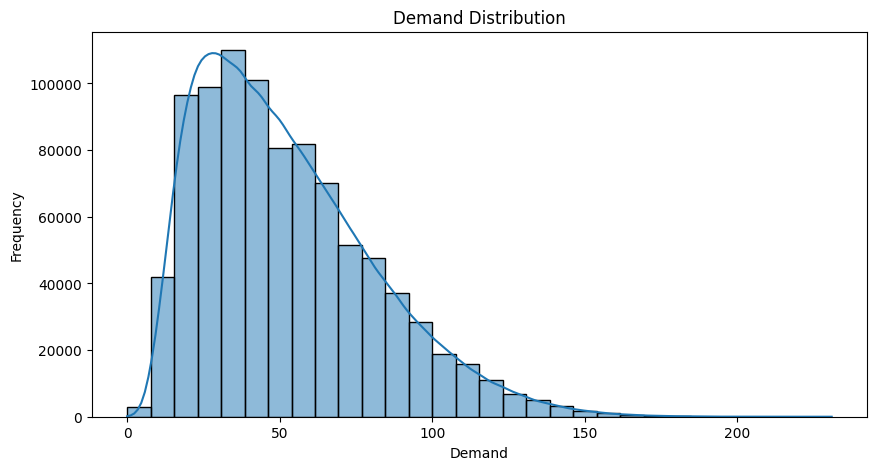

In [8]:
plt.figure(figsize=(10, 5))
sns.histplot(df['sales'], bins=30, kde=True)
plt.title('Demand Distribution')
plt.xlabel('Demand')
plt.ylabel('Frequency')
plt.show()

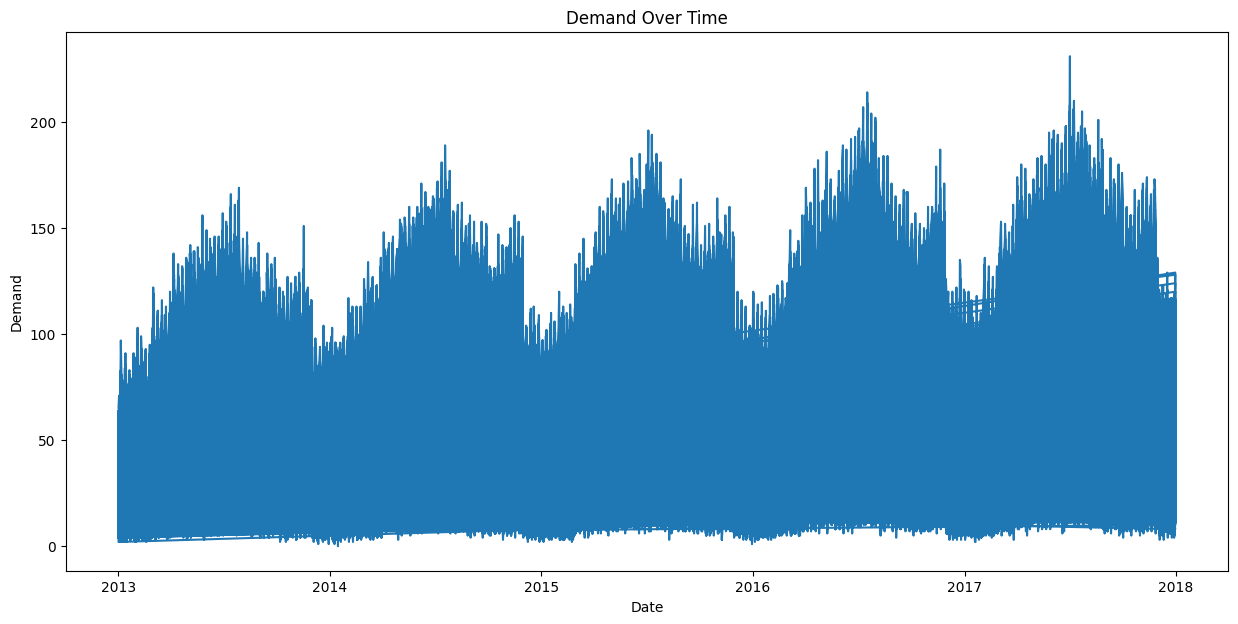

In [9]:
df['date'] = pd.to_datetime(df['date'])
plt.figure(figsize=(15, 7))
plt.plot(df['date'], df['sales'])
plt.title('Demand Over Time')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.show()

<Axes: title={'center': 'Monthly Demand'}, xlabel='month'>

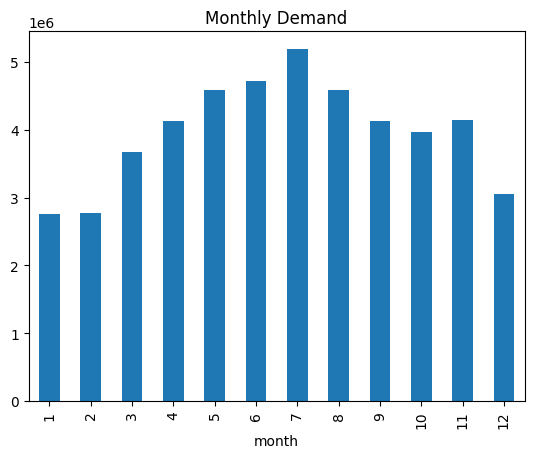

In [10]:
df['month'] = df['date'].dt.month
monthly_demand = df.groupby('month')['sales'].sum()
monthly_demand.plot(kind='bar', title='Monthly Demand')

<Axes: title={'center': 'Average Demand by Day of Week'}, xlabel='day_of_week'>

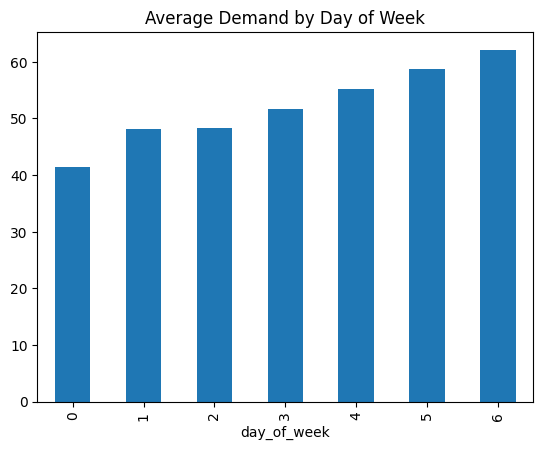

In [11]:
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
weekly_demand = df.groupby('day_of_week')['sales'].mean()
weekly_demand.plot(kind='bar', title='Average Demand by Day of Week')

<Axes: title={'center': 'Yearly Demand'}, xlabel='year'>

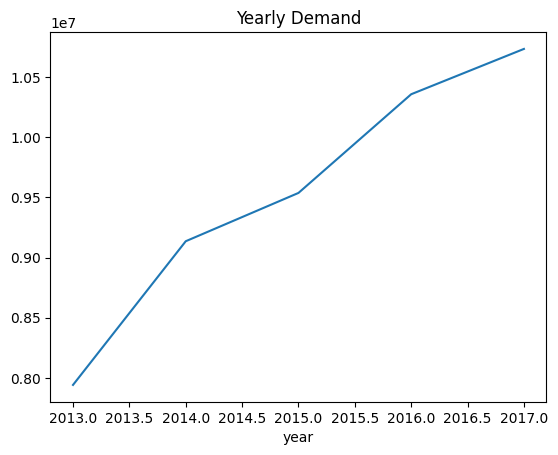

In [12]:
df['year'] = df['date'].dt.year
yearly_demand = df.groupby('year')['sales'].sum()
yearly_demand.plot(kind='line', title='Yearly Demand')

In [13]:
df['day'] = df['date'].dt.day
df['week_of_year'] = df['date'].dt.isocalendar().week
df.head()

,date,store,item,sales,month,day_of_week,year,day,week_of_year
0,2013-01-01,1,1,13,1,1,2013,1,1
1,2013-01-02,1,1,11,1,2,2013,2,1
2,2013-01-03,1,1,14,1,3,2013,3,1
3,2013-01-04,1,1,13,1,4,2013,4,1
4,2013-01-05,1,1,10,1,5,2013,5,1


In [14]:
# Shift the demand column by 1 day to get the previous day's demand
df['demand_lag_1'] = df['sales'].shift(1)

# Shift by 7 days to get demand from one week ago
df['demand_lag_7'] = df['sales'].shift(7)

df.head()

,date,store,item,sales,month,day_of_week,year,day,week_of_year,demand_lag_1,demand_lag_7
0,2013-01-01,1,1,13,1,1,2013,1,1,NaN,NaN
1,2013-01-02,1,1,11,1,2,2013,2,1,13.0,NaN
2,2013-01-03,1,1,14,1,3,2013,3,1,11.0,NaN
3,2013-01-04,1,1,13,1,4,2013,4,1,14.0,NaN
4,2013-01-05,1,1,10,1,5,2013,5,1,13.0,NaN


In [15]:
df.isna().sum()

date            0
store           0
item            0
sales           0
month           0
day_of_week     0
year            0
day             0
week_of_year    0
demand_lag_1    1
demand_lag_7    7
dtype: int64

In [16]:
mean_demand = df['sales'].mean()
df['demand_lag_1'].fillna(mean_demand, inplace=True)
df['demand_lag_7'].fillna(mean_demand, inplace=True)

/var/folders/xg/xfdptgfd30j5qj2w13xgqcq00000gn/T/ipykernel_17982/234933885.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['demand_lag_1'].fillna(mean_demand, inplace=True)
/var/folders/xg/xfdptgfd30j5qj2w13xgqcq00000gn/T/ipykernel_17982/234933885.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [17]:
df.isna().sum()

date            0
store           0
item            0
sales           0
month           0
day_of_week     0
year            0
day             0
week_of_year    0
demand_lag_1    0
demand_lag_7    0
dtype: int64

In [18]:
df['rolling_mean_7'] = df['sales'].rolling(window=7).mean()
df['rolling_mean_30'] = df['sales'].rolling(window=30).mean()

In [19]:
df.isna().sum()

date                0
store               0
item                0
sales               0
month               0
day_of_week         0
year                0
day                 0
week_of_year        0
demand_lag_1        0
demand_lag_7        0
rolling_mean_7      6
rolling_mean_30    29
dtype: int64

In [20]:
df['rolling_mean_7'] = df['sales'].rolling(window=7).mean()
df['rolling_mean_7'].fillna(df['sales'].mean(), inplace=True)

df['rolling_mean_30'] = df['sales'].rolling(window=7).mean()
df['rolling_mean_30'].fillna(df['sales'].mean(), inplace=True)

df.isna().sum()

/var/folders/xg/xfdptgfd30j5qj2w13xgqcq00000gn/T/ipykernel_17982/298807376.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['rolling_mean_7'].fillna(df['sales'].mean(), inplace=True)
/var/folders/xg/xfdptgfd30j5qj2w13xgqcq00000gn/T/ipykernel_17982/298807376.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting 

date               0
store              0
item               0
sales              0
month              0
day_of_week        0
year               0
day                0
week_of_year       0
demand_lag_1       0
demand_lag_7       0
rolling_mean_7     0
rolling_mean_30    0
dtype: int64

In [21]:
df['demand_pct_change'] = df['sales'].pct_change()
df.isna().sum()

date                 0
store                0
item                 0
sales                0
month                0
day_of_week          0
year                 0
day                  0
week_of_year         0
demand_lag_1         0
demand_lag_7         0
rolling_mean_7       0
rolling_mean_30      0
demand_pct_change    1
dtype: int64

In [22]:
df['demand_pct_change'] = df['demand_pct_change'].fillna(df['demand_pct_change'].mean())
df.isna().sum()

date                 0
store                0
item                 0
sales                0
month                0
day_of_week          0
year                 0
day                  0
week_of_year         0
demand_lag_1         0
demand_lag_7         0
rolling_mean_7       0
rolling_mean_30      0
demand_pct_change    0
dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   date               913000 non-null  datetime64[ns]
 1   store              913000 non-null  int64         
 2   item               913000 non-null  int64         
 3   sales              913000 non-null  int64         
 4   month              913000 non-null  int32         
 5   day_of_week        913000 non-null  int32         
 6   year               913000 non-null  int32         
 7   day                913000 non-null  int32         
 8   week_of_year       913000 non-null  UInt32        
 9   demand_lag_1       913000 non-null  float64       
 10  demand_lag_7       913000 non-null  float64       
 11  rolling_mean_7     913000 non-null  float64       
 12  rolling_mean_30    913000 non-null  float64       
 13  demand_pct_change  913000 non-null  float64 

In [24]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna()

,date,store,item,sales,month,day_of_week,year,day,week_of_year,demand_lag_1,demand_lag_7,rolling_mean_7,rolling_mean_30,demand_pct_change
1,2013-01-02,1,1,11,1,2,2013,2,1,13.0,52.250287,52.250287,52.250287,-0.153846
2,2013-01-03,1,1,14,1,3,2013,3,1,11.0,52.250287,52.250287,52.250287,0.272727
3,2013-01-04,1,1,13,1,4,2013,4,1,14.0,52.250287,52.250287,52.250287,-0.071429
4,2013-01-05,1,1,10,1,5,2013,5,1,13.0,52.250287,52.250287,52.250287,-0.230769
5,2013-01-06,1,1,12,1,6,2013,6,1,10.0,52.250287,52.250287,52.250287,0.200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
912995,2017-12-27,10,50,63,12,2,2017,27,52,41.0,51.000000,62.714286,62.714286,0.536585
912996,2017-12-28,10,50,59,12,3,2017,28,52,63.0,63.000000,62.142857,62.142857,-0.063492
912997,2017-12-29,10,50,74,12,4,2017,29,52,59.0,75.000000,62.000000,62.000000,0.254237
912998,2017-12-30,10,50,62,12,5,2017,30,52,74.0,70.000000,60.857143,60.857143,-0.162162


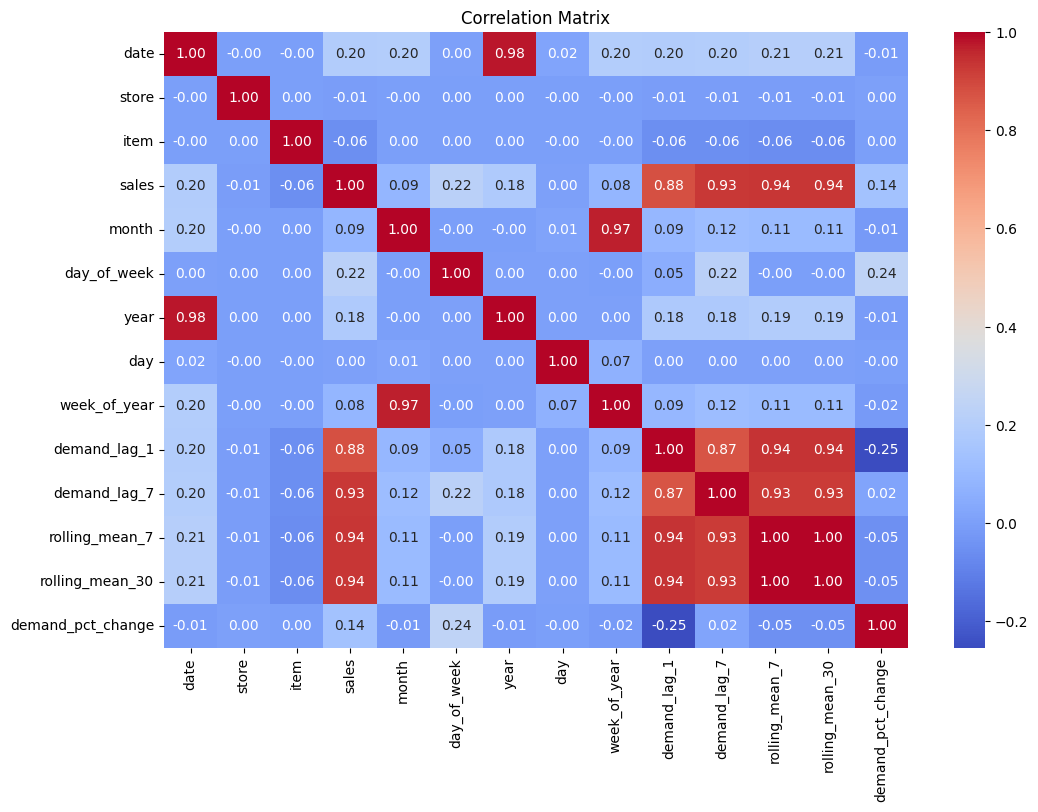

In [25]:
corr = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

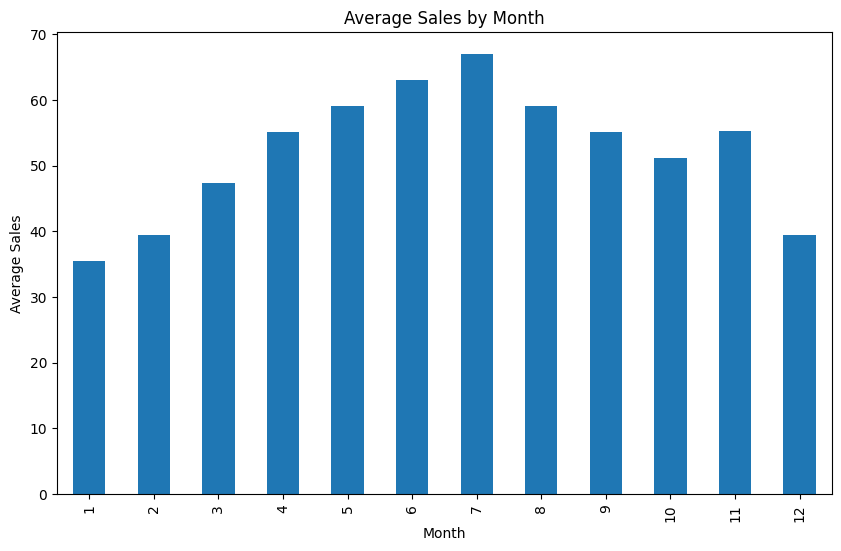

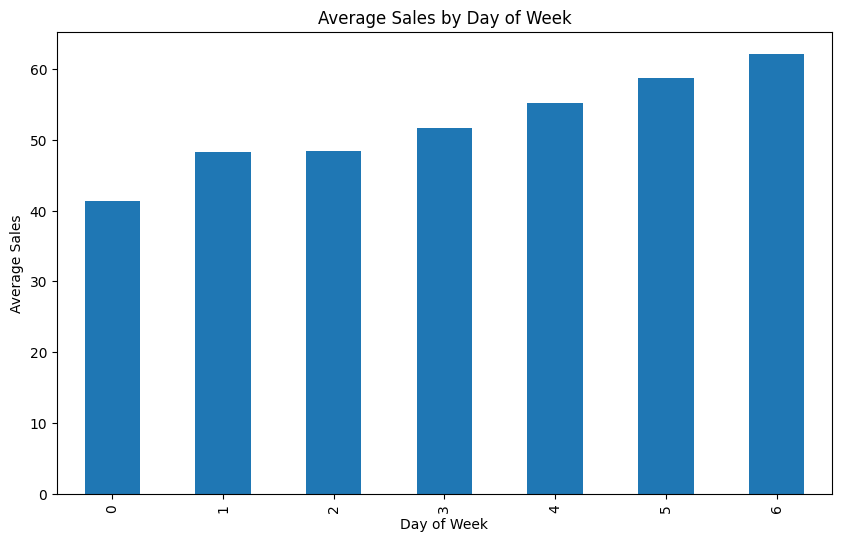

In [26]:
plt.figure(figsize=(10, 6))
df.groupby('month')['sales'].mean().plot(kind='bar')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.show()

plt.figure(figsize=(10, 6))
df.groupby('day_of_week')['sales'].mean().plot(kind='bar')
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.show()

In [27]:
print(df.isnull().sum())

X = df.drop(columns=['sales', 'date'])
y = df['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

date                 0
store                0
item                 0
sales                0
month                0
day_of_week          0
year                 0
day                  0
week_of_year         0
demand_lag_1         0
demand_lag_7         0
rolling_mean_7       0
rolling_mean_30      0
demand_pct_change    2
dtype: int64


In [28]:
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)

y_pred = rf_model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.023758926615553188


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Parameters from Grid Search: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Absolute Error of Random Forest Model: 0.02373992332968244


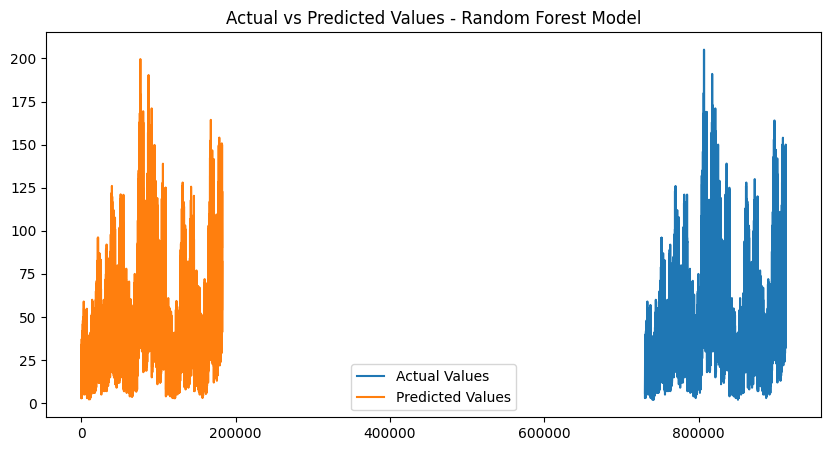

In [32]:
param_grid = {
    'n_estimators': [50, 100],       # Number of trees in the forest
    'max_depth': [5, 10, None],       # Maximum depth of each tree
    'min_samples_split': [2, 5],      # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2]         # Minimum samples at a leaf node
}

# Step 3: Set up TimeSeriesSplit and GridSearchCV
tscv = TimeSeriesSplit(n_splits=5)  # Time-series split for cross-validation

grid_search = GridSearchCV(estimator=rf_model,
                           param_grid=param_grid,
                           scoring='neg_mean_absolute_error',
                           cv=tscv,
                           verbose=1,
                           n_jobs=-1)

# Step 4: Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and model
best_rf_model = grid_search.best_estimator_
print("Best Parameters from Grid Search:", grid_search.best_params_)

# Step 5: Evaluate the model on test data
predictions = best_rf_model.predict(X_test)

# Calculate MAE
mae = mean_absolute_error(y_test, predictions)
print("Mean Absolute Error of Random Forest Model:", mae)

# Step 6: Optional - Plot predictions vs actual values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual Values")
plt.plot(predictions, label="Predicted Values")
plt.legend()
plt.title("Actual vs Predicted Values - Random Forest Model")
plt.show()